In [1]:
from mylib.statistic_test import *
from mylib.statistic_test import GetMultidayIndexmap, ReadCellReg
from mylib.multiday.core import MultiDayCore

code_id = "0313 - Conditional Probability for Field Maintain"
loc = join(figpath, code_id)
mkdir(loc)
sfn_loc = join(figpath, "SfN Poster", code_id)
mkdir(sfn_loc)

# This step is to call function `ConditionalProb_Interface` to calculate 
# the conditional probabilities for all spatial maps.

if os.path.exists(join(figdata, f'{code_id}.pkl')):
    with open(join(figdata, f'{code_id}.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = DataFrameEstablish(
        variable_names = [
            'Duration', 'Conditional Prob.', 'Conditional Recover Prob.',
            'Global Recover Prob.', 'Cumulative Prob.', 'Paradigm', 
            'On-Next Num', 'Off-Next Num'
        ], 
        f_member=['Type'], f = f_CellReg_modi, 
        function = ConditionalProb_Interface, 
        file_name = code_id, behavior_paradigm = 'CrossMaze'
    )

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0313 - Conditional Probability for Field Maintain is already existed!
        D:\Data\FinalResults\SfN Poster\0313 - Conditional Probability for Field Maintain is already existed!


# Fit Empirical Curves

In [7]:
from scipy.optimize import curve_fit
def exp_func(x, k, b):
    return 1 - np.exp(-k * (x-b))

def polynomial_converge2(x, k, b, c):
    return c - 1 / (k*x + b)

def kww_decay(x, a, b, c):
    return a*np.exp(-np.power(x/b, c))

def report_para(Data, name: str = 'KWW', key: str = 'Conditional Prob.'):
    """
    Report the fitted parameters for specified function.
    """
    mazes = ['Maze 1', 'Maze 2']
    mice = [10209, 10212, 10224, 10227, 10232, 10234]
    
    if name == 'KWW':
        params = [[], [], []]
    elif name == 'exp':
        params = [[], []]
    elif name == 'poly':
        params = [[], [], []]

    for maze in mazes:
        idx = np.where((Data['Paradigm'] == 'CrossMaze')&
                       (Data['Maze Type'] == maze)&
                       (np.isnan(Data[key]) == False))[0]
        if len(idx) == 0:
            continue
        if name == 'KWW':
            params0, _ = curve_fit(kww_decay, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100)
            params[0].append(params0[0])
            params[1].append(params0[1])
        elif name == 'exp':
            params0, _ = curve_fit(exp_func, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100)
            params[0].append(params0[0])
            params[1].append(params0[1])
        elif name == 'poly':
            bounds = ([0, -np.inf, 0], [np.inf, np.inf, 1])
            params0, _ = curve_fit(polynomial_converge2, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100, 
                                   bounds=bounds)
            params[0].append(params0[0])
            params[1].append(params0[1])
            params[2].append(params0[2])
                
    if name == 'KWW':
        print("KWW fitted parameters for all mice and both mazes -------------------------------")
        print("  b: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1])
        print("  c: ", np.mean(params[2]), np.std(params[2]))
        print("           ", params[2], end='\n\n')
    elif name == 'exp':
        print("exp fitted parameters for all mice and both mazes -------------------------------")
        print("  k: ", np.mean(params[0]), np.std(params[0]))
        print("           ", params[0])
        print("  x0: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1], end='\n\n')
    elif name == 'poly':
        print("poly fitted parameters for all mice and both mazes -------------------------------")
        print("  k: ", np.mean(params[0]), np.std(params[0]))
        print("           ", params[0])
        print("  b: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1])
        print("  c: ", np.mean(params[2]), np.std(params[2]))
        print("           ", params[2], end='\n\n')

colors = sns.color_palette("rocket", 3)[1:]
markercolors = [sns.color_palette("Blues", 3)[1], sns.color_palette("Blues", 3)[2]]
chancecolors = ['#D4C9A8', '#8E9F85', '#C3AED6', '#FED7D7']

# Fit for Maze A and B (Retention Probability)

In [13]:
#Data['hue'] = np.array([Data['Papadigm'][i] + ' ' + Data['Maze Type'][i] for i in range(Data['Duration'].shape[0])])
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

report_para(SubData, name='poly', key='Conditional Prob.')
report_para(SubData, name='exp', key='Conditional Prob.')
report_para(SubData, name='KWW', key='Conditional Recover Prob.')

idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]

initial_guesses = [0.9, 10, 0.5]  # Adjust these based on your data
# Bounds for the parameters: a between 0 and 1, b positive, c between 0 and 1
bounds = ([0, -np.inf, 0], [np.inf, np.inf, 1])
params1, _ = curve_fit(polynomial_converge2, 
                       SubData['Duration'][idx1], 
                       SubData['Conditional Prob.'][idx1]/100, 
                       bounds=bounds)
x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
print(params1)
params2, _ = curve_fit(polynomial_converge2, 
                       SubData['Duration'][idx2], 
                       SubData['Conditional Prob.'][idx2]/100, 
                       bounds=bounds)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
print(params2)

k1, b1, c1 = params1
k2, b2, c2 = params2

y1 = polynomial_converge2(x1, k1, b1, c1)
y2 = polynomial_converge2(x2, k2, b2, c2)

poly fitted parameters for all mice and both mazes -------------------------------
  k:  1.184292343073302 0.04723768110138671
            [1.137054661971915, 1.2315300241746885]
  b:  0.9439700437718039 0.01773731969543274
            [0.9617073634672367, 0.9262327240763712]
  c:  0.9876178207443731 0.010461575033112458
            [0.9980793957774855, 0.9771562457112606]

exp fitted parameters for all mice and both mazes -------------------------------
  k:  0.2120320827999596 0.0014738325231363758
            [0.21350591532309598, 0.21055825027682323]
  x0:  -3.06438540901966 0.03507118016727029
            [-3.0994565891869303, -3.0293142288523898]

KWW fitted parameters for all mice and both mazes -------------------------------
  b:  0.4669656142998724 0.23866977809232848
            [0.22829583620754393, 0.7056353923922009]
  c:  nan nan
            []

[1.13705466 0.96170736 0.9980794 ]
[1.23153002 0.92623272 0.97715625]


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_32672\911415591.py:9: RuntimeWarning: invalid value encountered in power
  return a*np.exp(-np.power(x/b, c))
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in s

# Visualize Fig. 4C

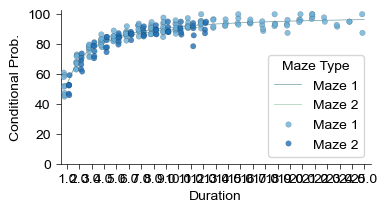

Maze A:
  S1:   Mean: 52.462570832416546, STD: 5.85874778166723, Max: 60.903495273686524, Min: 44.86074934882789, Median: 51.79314217067265, df: 7
  S8:   Mean: 89.77118353277692, STD: 2.800454986332996, Max: 94.71153846153845, Min: 86.57407407407408, Median: 89.92098331870062, df: 7
  Comparison: TtestResult(statistic=-17.238654994241426, pvalue=5.429833811606014e-07, df=7)
Maze B:
  S1:   Mean: 51.597290082056695, STD: 4.420322989197554, Max: 59.230431922823946, Min: 45.8234627665053, Median: 52.446073461468536, df: 5
  S8:   Mean: 89.17272001679864, STD: 2.0519182228310773, Max: 92.6086956521739, Min: 86.51685393258427, Median: 89.52589807852965, df: 5
  Comparison: TtestResult(statistic=-17.628662090051307, pvalue=1.0773318585827873e-05, df=5)


In [14]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)

ax.plot(x1-1, y1*100, color=colors[0], label='Maze 1', linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], label='Maze 2', linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData,
    hue = "Maze Type",
    palette = markercolors,
    edgecolor='black',
    size=4,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    dodge=True,
    jitter=0.1
)
ax.set_ylim(0, 103)
ax.set_yticks(np.linspace(0, 100, 6))
#plt.savefig(join(sfn_loc, "conditional prob.svg"))
plt.savefig(join(loc, 'Conditional prob.png'), dpi = 600)
plt.savefig(join(loc, 'Conditional prob.svg'), dpi = 600)
plt.show()

# Maze A
idx_m1_s1 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 1'))[0]
idx_m1_s8 = np.where((SubData['Duration'] == 8)&(SubData['Maze Type'] == 'Maze 1'))[0]
print(f"Maze A:")
print(f"  S1: ", end='')
print_estimator(SubData['Conditional Prob.'][idx_m1_s1])
print(f"  S8: ", end='')
print_estimator(SubData['Conditional Prob.'][idx_m1_s8])
print(f"  Comparison: {ttest_rel(SubData['Conditional Prob.'][idx_m1_s1], SubData['Conditional Prob.'][idx_m1_s8])}")

idx_m2_s1 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 2'))[0]
idx_m2_s8 = np.where((SubData['Duration'] == 8)&(SubData['Maze Type'] == 'Maze 2'))[0]
print("Maze B:")
print(f"  S1: ", end='')
print_estimator(SubData['Conditional Prob.'][idx_m2_s1])
print(f"  S8: ", end='')
print_estimator(SubData['Conditional Prob.'][idx_m2_s8])
print(f"  Comparison: {ttest_rel(SubData['Conditional Prob.'][idx_m2_s1], SubData['Conditional Prob.'][idx_m2_s8])}")


# Fit for Maze A and B (Recovery Probability)

In [15]:
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)
idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]
params1, _ = curve_fit(kww_decay, SubData['Duration'][idx1], SubData['Conditional Recover Prob.'][idx1]/100)
print("Conditional Recovery prob. -----------------------------------------")
x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
print("Maze 1", params1)
params2, _ = curve_fit(kww_decay, SubData['Duration'][idx2], SubData['Conditional Recover Prob.'][idx2]/100)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
print("Maze 2", params2)

y1 = kww_decay(x1, *params1)
y2 = kww_decay(x2, *params2)

Conditional Recovery prob. -----------------------------------------
Maze 1 [1.74774128 0.22576487 0.38308518]
Maze 2 [0.85637174 0.79247833 0.55266614]


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_32672\911415591.py:9: RuntimeWarning: invalid value encountered in power
  return a*np.exp(-np.power(x/b, c))


# Fig. 4G

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_32672\1045689640.py:18: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


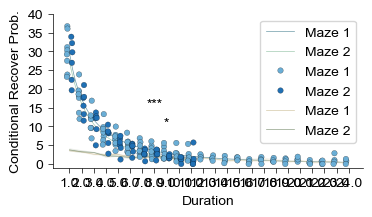

Maze A&B Conditional Recovery Prob. -----------------------------------------
Day  1 TtestResult(statistic=17.105848248958623, pvalue=2.7028874037775175e-10, df=13)
Day  2 TtestResult(statistic=14.426639860140677, pvalue=2.230679235739632e-09, df=13)
Day  3 TtestResult(statistic=10.203422375596887, pvalue=1.4236327402158807e-07, df=13)
Day  4 TtestResult(statistic=8.17323192689676, pvalue=1.7672764196379525e-06, df=13)
Day  5 TtestResult(statistic=6.763257562989987, pvalue=1.3350816342351796e-05, df=13)
Day  6 TtestResult(statistic=6.679815370409845, pvalue=1.516869726854104e-05, df=13)
Day  7 TtestResult(statistic=4.1877698827491425, pvalue=0.00106353246005401, df=13)
Day  8 TtestResult(statistic=2.3447748723536304, pvalue=0.03557075922073505, df=13)
Day  9 TtestResult(statistic=2.5281104467441824, pvalue=0.025214781580256144, df=13)
Day  10 TtestResult(statistic=1.2107349188487784, pvalue=0.24754947358696386, df=13)
Day  11 TtestResult(statistic=1.7475130767400113, pvalue=0.106063891

In [16]:
fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(x1-1, y1*100, color=colors[0], label='Maze 1', linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], label='Maze 2', linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    palette = markercolors,
    edgecolor='black',
    size=4,
    linewidth=0.15,
    ax = ax,
    dodge=True,
    jitter=0.1
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Conditional Recover Prob.'],
    hue = ShufData['Maze Type'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
ax.set_ylim(-1, 40)
ax.set_yticks(np.linspace(0, 40, 9))
ax.text(7, 15, "***", ha='center')
ax.text(8, 10, "*", ha='center')
plt.savefig(join(loc, 'Conditional recover prob.png'), dpi = 600)
plt.savefig(join(loc, 'Conditional recover prob.svg'), dpi = 600)
plt.show()

""""""
print("Maze A&B Conditional Recovery Prob. -----------------------------------------")
for i in range(1, 23):
    print("Day ",i, end=' ')
    print(ttest_rel(SubData['Conditional Recover Prob.'][SubData['Duration'] == i], 
                    ShufData['Conditional Recover Prob.'][ShufData['Duration'] == i]))
print()

# Maze A
idx_m1_s1 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 1'))[0]
idx_m1_s8 = np.where((SubData['Duration'] == 8)&(SubData['Maze Type'] == 'Maze 1'))[0]
print(f"Maze A:")
print(f"  S1: ", end='')
print_estimator(SubData['Conditional Recover Prob.'][idx_m1_s1])
print(f"  S8: ", end='')
print_estimator(SubData['Conditional Recover Prob.'][idx_m1_s8])
print(f"  Comparison: {ttest_rel(SubData['Conditional Recover Prob.'][idx_m1_s1], SubData['Conditional Recover Prob.'][idx_m1_s8])}")

idx_m2_s1 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 2'))[0]
idx_m2_s8 = np.where((SubData['Duration'] == 8)&(SubData['Maze Type'] == 'Maze 2'))[0]
print("Maze B:")
print(f"  S1: ", end='')
print_estimator(SubData['Conditional Recover Prob.'][idx_m2_s1])
print(f"  S8: ", end='')
print_estimator(SubData['Conditional Recover Prob.'][idx_m2_s8])
print(f"  Comparison: {ttest_rel(SubData['Conditional Recover Prob.'][idx_m2_s1], SubData['Conditional Recover Prob.'][idx_m2_s8])}")

# Retention for ReverseMaze & HairpinMaze Fig. 4D

In [9]:
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

# Fit parameters
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print("Hairpin&Reverse Conditional Prob.")
print(params1)
y1 = polynomial_converge2(x1, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = polynomial_converge2(x2, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = polynomial_converge2(x3, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = polynomial_converge2(x4, *params4)

Hairpin&Reverse Conditional Prob.
[1.30699547 0.63849022 0.93201704]
[0.95239468 0.89509473 0.94284111]
[1.39783147 0.68779354 1.        ]
[1.14715821 0.84328182 0.98799054]


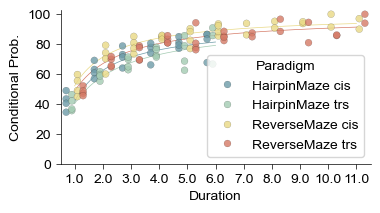

In [10]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=5,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    jitter=0.0,
    dodge=True
)
ax.set_ylim(0, 103)
ax.set_yticks(np.linspace(0, 100, 6))
plt.savefig(join(loc, '[Hairpin & Reverse] Conditional prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin & Reverse] Conditional prob.svg'), dpi = 600)
plt.show()

# Fit for Recovery Probability for ReverseMaze & HairpinMaze (Fig. 4H)

In [11]:
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)

# Fit parameters
bounds = [[0, 0, 0], [np.inf, np.inf, np.inf]]
initial_guesses = [2, 0.1, 0.35]
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params1)
y1 = kww_decay(x1, 1, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = kww_decay(x2, 1, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = kww_decay(x3, 1, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = kww_decay(x4, 1, *params4)

[0.38063737 0.45981362]
[0.38786995 0.49624079]
[0.48622433 0.50267941]
[0.42023699 0.47939663]


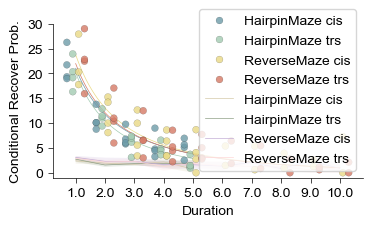

HP & MA reversed paradigms - Recovery Statistic Test
Day  1
TtestResult(statistic=16.69268480289537, pvalue=4.2529292273223785e-11, df=15)
Day  2
TtestResult(statistic=14.27450361137959, pvalue=3.900553247386827e-10, df=15)
Day  3
TtestResult(statistic=7.153236141508144, pvalue=3.3193027133222305e-06, df=15)
Day  4
TtestResult(statistic=10.19881219081679, pvalue=3.854311630915697e-08, df=15)
Day  5
TtestResult(statistic=3.409432138050629, pvalue=0.0038819194066257116, df=15)
Day  6
TtestResult(statistic=3.09405561441211, pvalue=0.05354359457066393, df=3)
Day  7
TtestResult(statistic=1.1655628111948415, pvalue=0.32803641328540656, df=3)
Day  8
TtestResult(statistic=1.3440614835841591, pvalue=0.27153423684323696, df=3)
Day  9
TtestResult(statistic=-0.32221841737644297, pvalue=0.7684357494160696, df=3)
Day  10
TtestResult(statistic=1.0210775837777746, pvalue=0.3823782314916928, df=3)



In [12]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)

sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=5,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    jitter=0.,
    dodge=True
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Conditional Recover Prob.'],
    hue = ShufData['Paradigm'],
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
ax.set_ylim(-1, 30)
ax.set_yticks(np.linspace(0, 30, 7))
#plt.savefig(join(sfn_loc, '[Hairpin&Reverse] conditional recover prob.svg'))
plt.savefig(join(loc, '[Hairpin&Reverse] Conditional recover prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin&Reverse] Conditional recover prob.svg'), dpi = 600)
plt.show()

print("HP & MA reversed paradigms - Recovery Statistic Test")
for i in range(1, 11):
    print("Day ",i)
    print(ttest_rel(SubData['Conditional Recover Prob.'][np.where((SubData['Duration'] == i))[0]],
                    ShufData['Conditional Recover Prob.'][np.where((SubData['Duration'] == i))[0]]))
print()


# Fig. 3C Total Recovery Probability (Maze A & B)

In [20]:
# Global Recovery Prob.
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)

idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]

params1, _ = curve_fit(kww_decay, SubData['Duration'][idx1], SubData['Global Recover Prob.'][idx1]/100,
                       bounds=[[0, 0, 0], [np.inf, np.inf, 1]],
                       p0=[0.5, 0.5, 0.5])
params2, _ = curve_fit(kww_decay, SubData['Duration'][idx2], SubData['Global Recover Prob.'][idx2]/100,
                       bounds=[[0, 0, 0], [np.inf, np.inf, 1]],
                       p0=[0.5, 0.5, 0.5])

idx_dur_1 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 1'))[0]
idx_dur_2 = np.where((SubData['Duration'] == 1)&(SubData['Maze Type'] == 'Maze 2'))[0]
print_estimator(SubData['Global Recover Prob.'][idx_dur_1])
print_estimator(SubData['Global Recover Prob.'][idx_dur_2])
print("Maze A&B global recover prob.")
print(params1)
print(params2, end='\n\n')

x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
y1 = kww_decay(x1, *params1)
y2 = kww_decay(x2, *params2)
colors = sns.color_palette("rocket", 3)[1:]

  Mean: 27.143837678348635, STD: 4.270779622088894, Max: 34.086306278236485, Min: 20.728392824787097, Median: 27.655610726775414, df: 7
  Mean: 24.346064330161013, STD: 4.809772907529146, Max: 29.881756756756754, Min: 16.444629475437136, Median: 25.620153361321503, df: 5
Maze A&B global recover prob.
[6.19169549 0.0625754  0.41137431]
[3.05237853 0.1535382  0.49518752]



C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_11532\3818820244.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


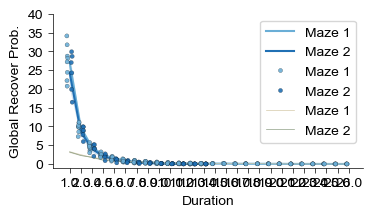

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_11532\3818820244.py:74: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


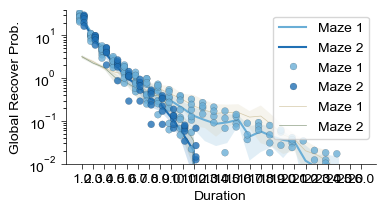

Maze A&B statistic test global recovery.
Day  1
LeveneResult(statistic=18.0003189002172, pvalue=0.0002476822576635462)
TtestResult(statistic=16.707695354849093, pvalue=3.6256943156826756e-10, df=13)
Day  2
LeveneResult(statistic=8.205042911424842, pvalue=0.00815769607855549)
TtestResult(statistic=18.152807849032857, pvalue=1.2853682284491732e-10, df=13)
Day  3
LeveneResult(statistic=11.61354488420859, pvalue=0.002141870805253108)
TtestResult(statistic=10.459753114421941, pvalue=1.065433004123557e-07, df=13)
Day  4
LeveneResult(statistic=1.636626795232132, pvalue=0.2120885583086989)
TtestResult(statistic=8.825105686600734, pvalue=7.515076120856849e-07, df=13)
Day  5
LeveneResult(statistic=0.9605012956169661, pvalue=0.33609263902989417)
TtestResult(statistic=3.45632975695276, pvalue=0.004256092929836817, df=13)
Day  6
LeveneResult(statistic=0.08693818659090814, pvalue=0.7704478870595611)
TtestResult(statistic=1.8728831729608384, pvalue=0.0837433999184119, df=13)
Day  7
LeveneResult(stati

In [21]:
fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
#ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
#ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
sns.lineplot(
    x = SubData['Duration']-1,
    y = SubData['Global Recover Prob.'],
    hue = SubData['Maze Type'],
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    err_kws={"edgecolor": None},
    ax = ax
)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    edgecolor='black',
    size=3,
    linewidth=0.15,
    alpha=0.9,
    jitter=0.1,
    dodge=True,
    ax = ax
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    data=ShufData,
    hue=ShufData['Maze Type'],
    palette=chancecolors,
    err_kws={"edgecolor": None},
    linewidth = 0.5,
    ax = ax
)
ax.set_ylim(-1, 40)
ax.set_yticks(np.linspace(0, 40, 9))

plt.savefig(join(loc, 'Global recover prob.png'), dpi = 600)
plt.savefig(join(loc, 'Global recover prob.svg'), dpi = 600)
plt.show()

fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
#ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
#ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
sns.lineplot(
    x = SubData['Duration']-1,
    y = SubData['Global Recover Prob.'],
    hue = SubData['Maze Type'],
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    err_kws={"edgecolor": None},
    ax = ax
)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    edgecolor='black',
    size=5,
    linewidth=0.1,
    alpha=0.8,
    jitter=0,
    dodge=True,
    ax = ax
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    data=ShufData,
    hue=ShufData['Maze Type'],
    palette=chancecolors,
    err_kws={"edgecolor": None},
    linewidth = 0.5,
    ax = ax
)
ax.semilogy()
ax.set_ylim(0.01, 40)

plt.savefig(join(loc, 'Global recover prob [semilogy].png'), dpi = 600)
plt.savefig(join(loc, 'Global recover prob [semilogy].svg'), dpi = 600)
plt.show()
print("Maze A&B statistic test global recovery.")
for i in range(1, 14):
    print("Day ", i)
    print(levene(SubData['Global Recover Prob.'][np.where(SubData['Duration'] == i)[0]], 
                ShufData['Global Recover Prob.'][np.where(ShufData['Duration'] == i)[0]]))
    try:
        print(ttest_rel(SubData['Global Recover Prob.'][np.where(SubData['Duration'] == i)[0]], 
                    ShufData['Global Recover Prob.'][np.where(ShufData['Duration'] == i)[0]]))
    except:
        pass



# Global Recovery Proportion for Hairpin & Reverse Maze (Fig. 3D)

In [11]:
# Global Recovery Prob. Hairpin
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)


# Fit parameters
bounds = [[0, 0, 0], [np.inf, np.inf, 1]]
initial_guesses = [1, 1, 0.5]
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params1)
y1 = kww_decay(x1, 5, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = kww_decay(x2, 5, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = kww_decay(x3, 5, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = kww_decay(x4, 5, *params4)

colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']

[0.07375384 0.45946461]
[0.05933831 0.43244119]
[0.0879279 0.4700667]
[0.07465055 0.44891384]


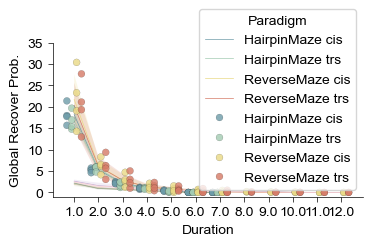

All test
Day  1
TtestResult(statistic=14.60233546810207, pvalue=2.83502792759467e-10, df=15)
Day  2
TtestResult(statistic=15.479657704012094, pvalue=1.243806581670175e-10, df=15)
Day  3
TtestResult(statistic=6.862689168121625, pvalue=5.389592230285645e-06, df=15)
Day  4
TtestResult(statistic=10.759145878129805, pvalue=1.8923659733394314e-08, df=15)
Day  5
TtestResult(statistic=2.6498973152121787, pvalue=0.018195095028744838, df=15)
Day  6
TtestResult(statistic=2.035111486983397, pvalue=0.05990820648105821, df=15)
Day  7
TtestResult(statistic=-0.9735859908453187, pvalue=0.34570199345524555, df=15)
Day  8
TtestResult(statistic=-1.2865092625542018, pvalue=0.28855569715648843, df=3)
Day  9
TtestResult(statistic=-1.7287812715524258, pvalue=0.18229211270140067, df=3)
Day  10
TtestResult(statistic=-0.659714676687874, pvalue=0.5565614431548246, df=3)



In [18]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
#ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
#ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
#ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
#ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)
sns.lineplot(
    x = SubData['Duration']-1,
    y = SubData['Global Recover Prob.'],
    hue = SubData['Paradigm'],
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=5,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    dodge=True,
    jitter=0
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    hue = ShufData['Paradigm'],
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    legend=False,
    ax = ax
)
ax.set_ylim(-1, 35)
ax.set_yticks(np.linspace(0, 35, 8))

plt.savefig(join(loc, '[Hairpin&Reverse] Global recover prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin&Reverse] Global recover prob.svg'), dpi = 600)
plt.show()

print("All test")
for i in range(1, 11):
    print("Day ",i)
    print(ttest_rel(SubData['Global Recover Prob.'][np.where((SubData['Duration'] == i))[0]],
                    ShufData['Global Recover Prob.'][np.where((SubData['Duration'] == i))[0]]))
print()

# Identify Sexual Differences

In [6]:
Data['Paradm'] = []
for i in tqdm(range(Data['Duration'].shape[0])):
    if Data['Paradigm'][i] == 'CrossMaze':
        Data['Paradm'].append('MA') if Data['Maze Type'][i] == 'Maze 1' else Data['Paradm'].append('MB')
    elif Data['Paradigm'][i] == 'HairpinMaze cis':
        Data['Paradm'].append('HPf')
    elif Data['Paradigm'][i] == 'HairpinMaze trs':
        Data['Paradm'].append('HPb')
    elif Data['Paradigm'][i] == 'ReverseMaze cis':
        Data['Paradm'].append('MAf')
    elif Data['Paradigm'][i] == 'ReverseMaze trs':
        Data['Paradm'].append('MAb')
Data['Paradm'] = np.array(Data['Paradm'])

SubData_ma = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'MA') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])
SubData_mb = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'MB') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])
SubData_hpf = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'HPf') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])
SubData_hpb = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'HPb') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])
SubData_maf = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'MAf') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])
SubData_mab = SubDict(Data, Data.keys(), idx=np.where(
    (Data['Paradm'] == 'MAb') &
    (np.isnan(Data['Conditional Prob.']) == False) &
    (Data['Type'] != 'Shuffle') &
    (Data['Duration'] > 0)
)[0])

100%|██████████| 790/790 [00:00<?, ?it/s]


7.761386413494042e-07
3.4177232152331957e-06


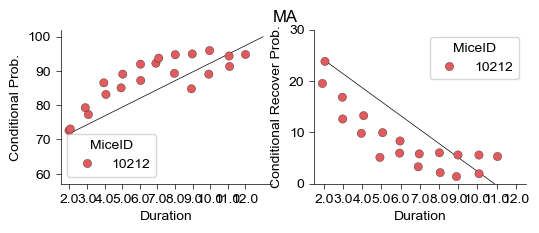

0.002143098365817251
0.0015442617801425752


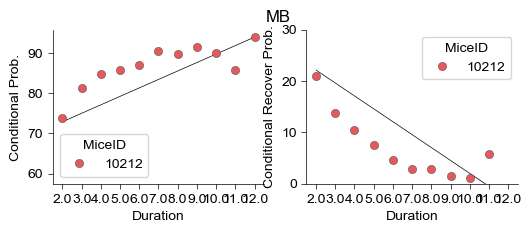

In [25]:
def process_data(data_, k: str):
    data = cp.deepcopy(data_)
    duration = np.unique(data['Duration'])
    subtracted_mean = np.zeros(duration.shape[0])
    for i, d in enumerate(duration):
        idx = np.where((data['Duration'] == d)&(data['MiceID'] == 10212))[0]
        subtracted_mean[i] = np.nanmean(data[k][idx])
        idx_all = np.where(data['Duration'] == d)[0]
        data[k][idx_all] = data[k][idx_all] - subtracted_mean[i]
    return data

SubData_ma_sub = SubDict(SubData_ma, SubData_ma.keys(), idx=np.where(SubData_ma['MiceID'] == 10212)[0])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData_ma_sub,
    size=6, 
    edgecolor='black',
    linewidth=0.2,
    hue='MiceID',
    palette=['#e05b5d'],
    ax = ax0
)
idx = np.where(np.isnan(SubData_ma_sub['Conditional Prob.']) == False)[0]
lres = linregress(SubData_ma_sub['Duration'][idx], SubData_ma_sub['Conditional Prob.'][idx])
x = np.array([1, 12])
y = lres.intercept + lres.slope * x
print(lres.pvalue)
ax0.set_xlim(0.5, 12.5)
ax0.plot(x, y, color='k', linewidth=0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData_ma_sub,
    ax = ax1,
    size=6, 
    edgecolor='black',
    linewidth=0.2,
    hue='MiceID',
    palette=['#e05b5d'],
)
ax1.set_xlim(0.5, 11.5)
idx = np.where(np.isnan(SubData_ma_sub['Conditional Recover Prob.']) == False)[0]
lres = linregress(SubData_ma_sub['Duration'][idx], SubData_ma_sub['Conditional Recover Prob.'][idx])
x = np.array([1, 11])
ax1.set_ylim(0, 30)
y = lres.intercept + lres.slope * x
print(lres.pvalue)
ax1.plot(x, y, color='k', linewidth=0.5)
plt.suptitle("MA")
plt.savefig(join(loc, 'MA mouse 10212.png'), dpi = 600)
plt.savefig(join(loc, 'MA mouse 10212.svg'), dpi = 600)
plt.show()


SubData_mb_sub = SubDict(SubData_mb, SubData_mb.keys(), idx=np.where(SubData_mb['MiceID'] == 10212)[0])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData_mb_sub,
    ax = ax0,
    size=6, 
    edgecolor='black',
    linewidth=0.2,
    hue='MiceID',
    palette=['#e05b5d'],
)
idx = np.where(np.isnan(SubData_mb_sub['Conditional Prob.']) == False)[0]
lres = linregress(SubData_mb_sub['Duration'][idx], SubData_mb_sub['Conditional Prob.'][idx])
x = np.array([1, 11])
y = lres.intercept + lres.slope * x
print(lres.pvalue)
ax0.set_xlim(0.5, 11.5)
ax0.plot(x, y, color='k', linewidth=0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData_mb_sub,
    size=6, 
    edgecolor='black',
    linewidth=0.2,
    hue='MiceID',
    palette=['#e05b5d'],
    ax = ax1,
)   
ax1.set_xlim(0.5, 11.5)
idx = np.where(np.isnan(SubData_mb_sub['Conditional Recover Prob.']) == False)[0]
lres = linregress(SubData_mb_sub['Duration'][idx], SubData_mb_sub['Conditional Recover Prob.'][idx])
x = np.array([1, 11])
ax1.set_ylim(0, 30)
y = lres.intercept + lres.slope * x 
print(lres.pvalue)
ax1.plot(x, y, color='k', linewidth=0.5)    
plt.suptitle("MB")
plt.savefig(join(loc, 'MB mouse 10212.png'), dpi = 600)
plt.savefig(join(loc, 'MB mouse 10212.svg'), dpi = 600)
plt.show()